In [ ]:
!pip install opencv-python scikit-image tensorflow ultralytics

In [33]:
from skimage import feature
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from ultralytics import YOLO
import torch
import torchvision.transforms as transforms

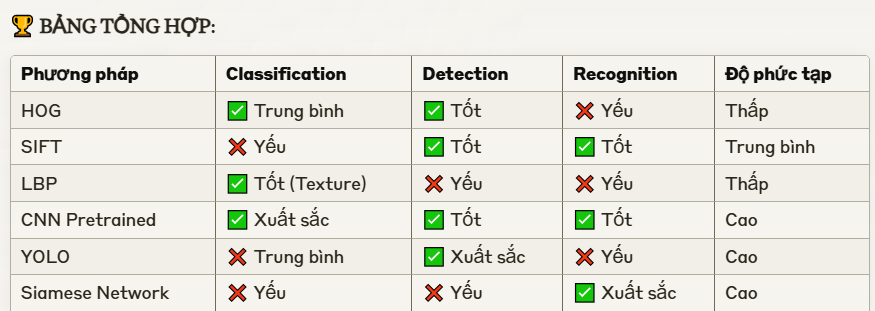

In [7]:
kaggle_input_path = '/kaggle/input/dog-cat-feature-extraction/'

## 1.Traditional FE

### 1.1 HOG

In [8]:
def extract_hog_features(image_path,
                        resize_scale = (64, 128),
                        orientations =9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=False,
                        transform_sqrt=True
                         ):
    # Resize và chuẩn hóa kích thước
    image = cv2.imread(image_path)
    image = cv2.resize(image, resize_scale)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Trích xuất HOG
    hog_features = feature.hog(
        image, 
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=visualize,
        transform_sqrt=transform_sqrt
    )
    
    return hog_features

In [10]:
hog_features = extract_hog_features(kaggle_input_path+'dog.png')
hog_features

array([0.22689256, 0.16213017, 0.09062567, ..., 0.07117908, 0.05052505,
       0.08804722])

In [24]:
hog_features.shape

(3780,)

### 1.2 Local Binary Patterns LBP

In [17]:
def extract_lbp_features(image_path,
                        P=8,   
                        R=1,
                        method='uniform',
                        bins=np.arange(0, 10)
                         ):
    image = cv2.imread(image_path)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Trích xuất LBP
    lbp = feature.local_binary_pattern(
        image, 
        P=P,    # Số điểm lân cận
        R=R,    # Bán kính
        method=method  # Phương pháp thống nhất
    )
    
    # Tính histogram
    (hist, _) = np.histogram(
        lbp.ravel(),
        bins=bins,
        range=(0, 9)
    )
    
    # Chuẩn hóa histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    return hist

In [18]:
lbp_feature = extract_lbp_features(kaggle_input_path+'dog.png')
lbp_feature

array([0.08839844, 0.10026693, 0.06714193, 0.09011719, 0.1211849 ,
       0.09352214, 0.07636068, 0.0944987 , 0.26850911])

In [23]:
lbp_feature.shape

(9,)

### 1.3 SIFT (Scale-Invariant Feature Transform)

In [19]:
def sift_feature_extraction(image_path):
    image = cv2.imread(image_path)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Khởi tạo SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints và compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    return keypoints, descriptors

In [21]:
kp, des = sift_feature_extraction(kaggle_input_path+'dog.png')

In [22]:
des.shape

(2113, 128)

## 2. Deep Learning FE

In [38]:
def load_image(image_path, target_size=(224, 224)):
    """
    Tải ảnh và tiền xử lý để đưa vào mô hình ResNet.
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)  # Resize về kích thước 224x224
    img = img / 255.0  # Chuẩn hóa pixel về [0, 1]
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension
    return img

### 2.1 Resnet18

In [14]:
def resnet18_feature_extractor(input_shape=(224, 224, 3)):
    """
    Tạo ResNet-18 để trích xuất đặc trưng từ ảnh.
    """
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)  # Pooling để giảm chiều dữ liệu
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    return feature_extractor

In [39]:
# Tải mô hình ResNet-18
feature_extractor = resnet18_feature_extractor()

# Tải một hình ảnh và tiền xử lý
image = load_image(kaggle_input_path+'dog.png')

# Trích xuất đặc trưng
features = feature_extractor.predict(image)
print("Features shape:", features.shape)
print("Features:", features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Features shape: (1, 2048)
Features: [[          0           0           0 ...      2.0256           0           0]]


### 2.2 VGG16

In [15]:
def vgg16_feature_extractor(input_shape=(224, 224, 3)):
    """
    Tạo mô hình VGG16 để trích xuất đặc trưng từ ảnh.
    """
    base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)  # Pooling để giảm chiều
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    return feature_extractor

In [17]:
# Tạo mô hình VGG16 để trích xuất đặc trưng
feature_extractor_vgg16 = vgg16_feature_extractor()
# Tải ảnh và trích xuất đặc trưng
image = load_image(kaggle_input_path+'dog.png')
features_vgg16 = feature_extractor_vgg16.predict(image)
print("VGG16 Features shape:", features_vgg16.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
VGG16 Features shape: (1, 512)


### 2.3 EfficientNet

In [19]:
def efficientnet_feature_extractor(input_shape=(224, 224, 3)):
    """
    Tạo mô hình EfficientNet để trích xuất đặc trưng từ ảnh.
    """
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base_model.output)  # Pooling để giảm chiều
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    return feature_extractor

In [20]:
# Tạo mô hình EfficientNet để trích xuất đặc trưng
feature_extractor_efficientnet = efficientnet_feature_extractor()
image = load_image(kaggle_input_path+'dog.png')
# Tải ảnh và trích xuất đặc trưng
features_efficientnet = feature_extractor_efficientnet.predict(image)
print("EfficientNet Features shape:", features_efficientnet.shape)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
EfficientNet Features shape: (1, 1280)


### 2.4 YOLO

In [29]:
# Tải mô hình YOLO (YOLOv8 hoặc YOLOv5 pre-trained)
model = YOLO('yolov8s.pt')  # Có thể chọn 'yolov8s.pt', 'yolov5m.pt', etc.

100%|██████████| 21.5M/21.5M [00:00<00:00, 95.0MB/s]


In [ ]:
# Dự đoán và lấy kết quả
# convert img to RGB
img = cv2.imread(kaggle_input_path+'dog.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0
img = transforms.ToTensor()(img).float()
img = img.unsqueeze(0)
features = model.model.model(img)  
# In thông tin chi tiết
print("Feature Vector Shape:", features.shape)